### This file presents all the code and results for the submitted paper

In [3]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1 Processing data

In [ ]:
# load data 
y_train, tx_train, ids_train = load_csv_data("train.csv")

# drop the NA value
tx_train = fix_null_value(tx_train)

# raw data visualized by boxplot to get a sense of it
box_tx_train = (tx_train - np.mean(tx_train,axis=0)) / np.std(tx_train,axis=0)
plt.figure(figsize=(20,10))
plt.rcParams['boxplot.flierprops.markersize'] = 1
plt.boxplot(box_tx_train,widths = 0.7)
plt.ylim(-15, 35)
plt.xlabel('X_feature')
plt.savefig('boxplot.png', bbox_inches='tight')


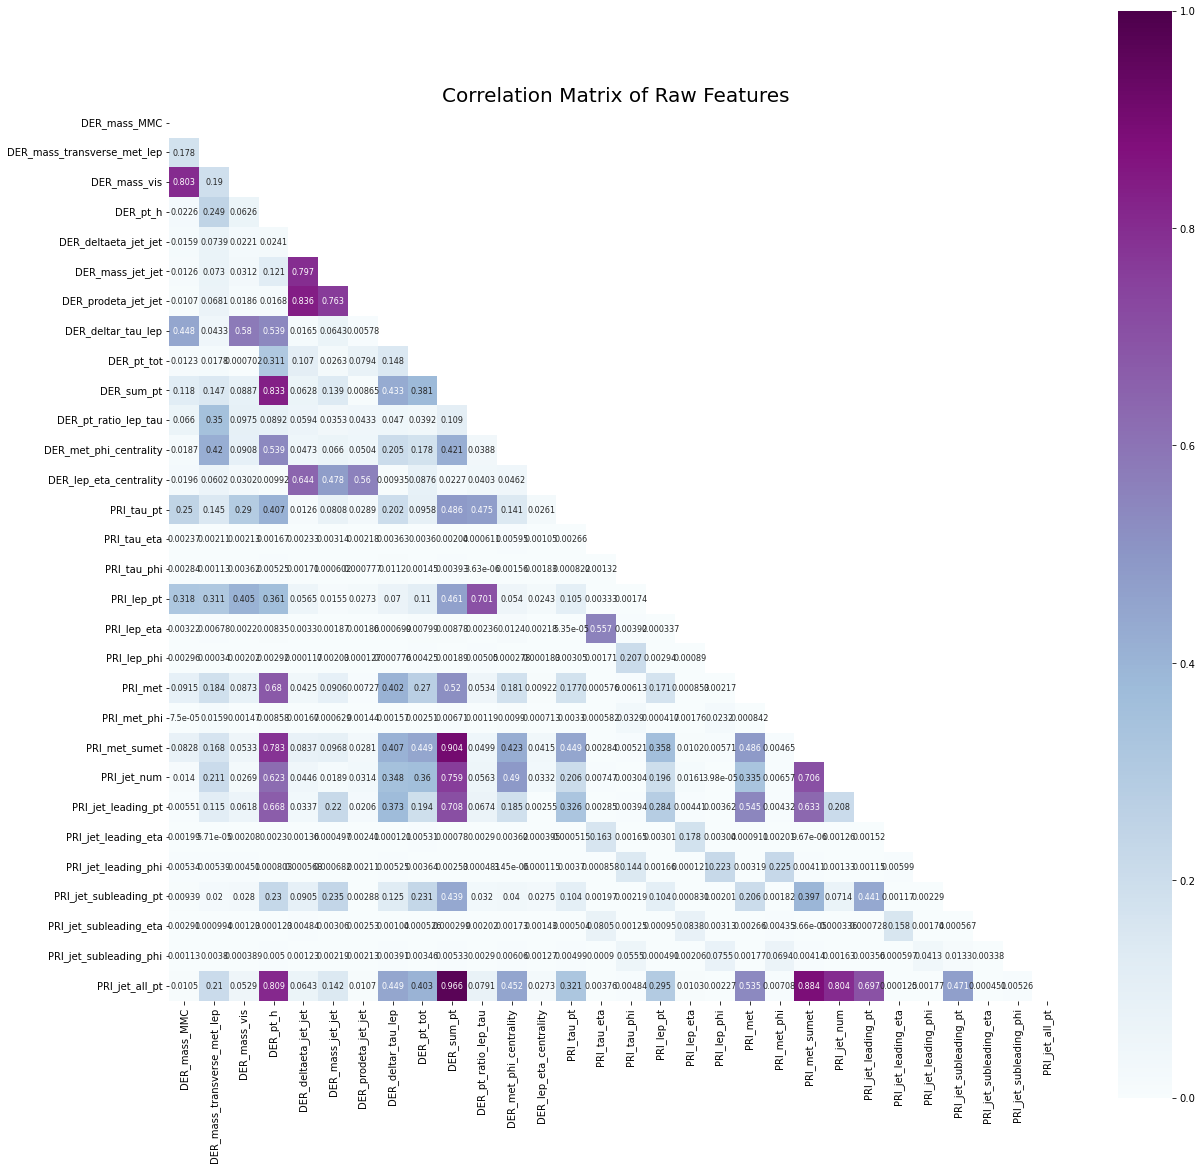

In [37]:
# Heatmap to show the correalation matrix
head = np.genfromtxt("train.csv", delimiter=",", dtype=str, max_rows=1)
head = head[2:32]
corr = np.corrcoef(tx_train.T)

mask = np.zeros_like(corr, dtype = bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot()
sns.heatmap(np.abs(corr), ax=ax, cmap="BuPu",mask = mask, square=True, fmt='.3g',\
            xticklabels=head, yticklabels=head, vmax=1, vmin=0 , annot=True, annot_kws={'size':8})
plt.title("Correlation Matrix of Raw Features", fontsize = 20)
plt.savefig('Correlation Matrix of Raw Features.png', bbox_inches='tight')


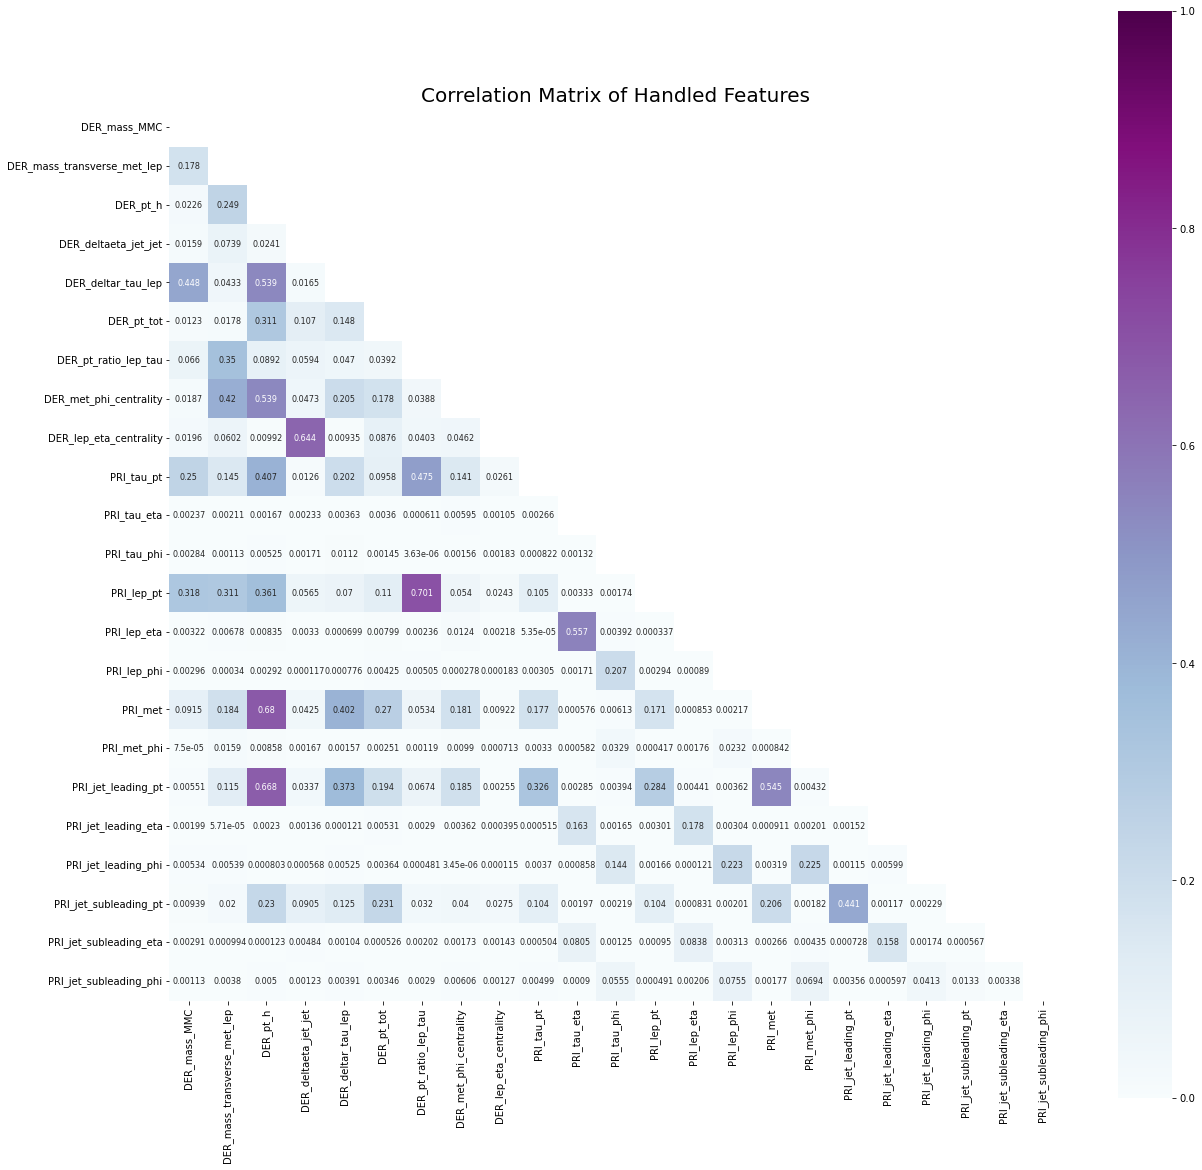

In [38]:
# Removal of highly relevant features
corr[mask] = 0
delete_index = list(set(np.where(np.abs(corr) >= 0.75)[0]))
tx_train = delete_related_features(tx_train, delete_index)

head = np.delete(head,delete_index)
corr = np.corrcoef(tx_train.T)

mask = np.zeros_like(corr, dtype = bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot()
sns.heatmap(np.abs(corr), ax=ax, cmap="BuPu",mask = mask, square=True, fmt='.3g',\
            xticklabels=head, yticklabels=head, vmax=1, vmin=0 , annot=True, annot_kws={'size':8})
plt.title("Correlation Matrix of Handled Features", fontsize = 20)
plt.savefig('Correlation Matrix of Handled Features.png', bbox_inches='tight')


In [65]:
# standardize
tx_train = (tx_train - np.mean(tx_train,axis=0)) / np.std(tx_train,axis=0)

# map
y_train[y_train == -1] = 0

# build polynomial features
degree = 3
tx_train = build_poly(tx_train, degree)

# Set set-off
tx_train = np.c_[np.ones((tx_train.shape[0], 1)), tx_train]

## Step 2 Predict by six different methods

### 1) ridge_regression

Loss with Ridge Regression:  0.07745126146442906
Loss with Ridge Regression:  0.07734149259345299
Loss with Ridge Regression:  0.07741937123028983
Loss with Ridge Regression:  0.07747069795473434
Loss with Ridge Regression:  0.0774414649436144
Loss with Ridge Regression:  0.07745126146442906
Loss with Ridge Regression:  0.07734149259345299
Loss with Ridge Regression:  0.07741937123028982
Loss with Ridge Regression:  0.07747069795473432
Loss with Ridge Regression:  0.0774414649436144
Loss with Ridge Regression:  0.07745126146442913
Loss with Ridge Regression:  0.07734149259345306
Loss with Ridge Regression:  0.0774193712302899
Loss with Ridge Regression:  0.0774706979547344
Loss with Ridge Regression:  0.07744146494361448
Loss with Ridge Regression:  0.0774512614644308
Loss with Ridge Regression:  0.0773414925934547
Loss with Ridge Regression:  0.07741937123029159
Loss with Ridge Regression:  0.07747069795473614
Loss with Ridge Regression:  0.07744146494361616
Loss with Ridge Regression

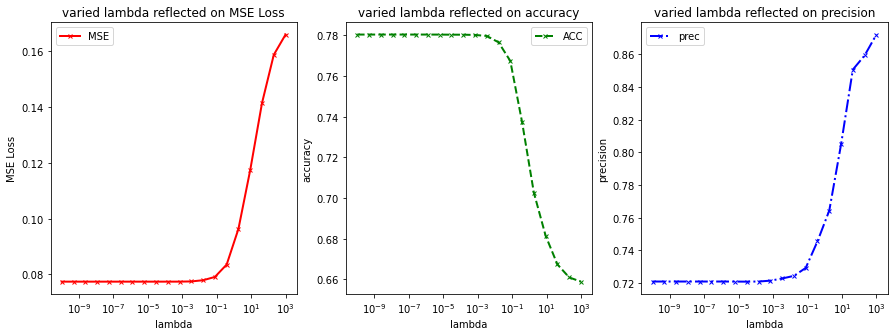

In [66]:
# Find best lambda for ridge_regression
num = y_train.shape[0]
seed = 111
k_fold = 5
k_indices = build_k_indices(num, k_fold, seed)
    
ridge_regression_loop(y_train, tx_train, k_indices, k_fold)

we got the best lambda is 1e-5

In [67]:
losses = []
accs = []
lambda_ = 1e-5
for k in range(k_fold):
    x_tr, x_val, y_tr, y_val = cross_validation(y_train, tx_train, k_indices, k)
    initial_w = np.zeros((x_tr.shape[1],1))
    w, loss = ridge_regression(y_tr, x_tr, lambda_)
    y_pred = predict_labels(w, x_val)
    acc = _accuracy(y_pred, y_val)
    accs.append(acc)
    losses.append(loss)
    print("test prediction acc of fold " + str(k) + " is " + str(acc))
print("Average test prediction accuracy over " + str(k_fold) + " folds is " + str(np.mean(accs)))
print("Average loss over " + str(k_fold) + " folds is " + str(np.mean(losses)))

Loss with Ridge Regression:  0.07745126283760571
test prediction acc of fold 0 is 0.781
Loss with Ridge Regression:  0.07734149394765631
test prediction acc of fold 1 is 0.7802
Loss with Ridge Regression:  0.07741937262619127
test prediction acc of fold 2 is 0.7808
Loss with Ridge Regression:  0.07747069937862554
test prediction acc of fold 3 is 0.7805
Loss with Ridge Regression:  0.0774414663180633
test prediction acc of fold 4 is 0.7793
Average test prediction accuracy over 5 folds is 0.78036
Average loss over 5 folds is 0.07742485902162843


### 2) Gradient Descent using logistic regression

In [ ]:
max_iters = 100
gamma = 1e-9
losses = []
accs = []
for k in range(k_fold):
    x_tr, x_val, y_tr, y_val = cross_validation(y_train, tx_train, k_indices, k)
    initial_w = np.zeros((x_tr.shape[1],1))
    w, loss = logistic_regression(y_tr, x_tr, initial_w, max_iters, gamma)
    y_pred = predict_labels(w, x_val)
    acc = _accuracy(y_pred, y_val)
    accs.append(acc)
    losses.append(loss)
    print("test prediction acc of fold " + str(k) + " is " + str(_accuracy(y_pred, y_val)))
print("Average test prediction accuracy over " + str(k_fold) + " folds is " + str(np.mean(accs)))
print("Average loss over " + str(k_fold) + " folds is " + str(np.mean(losses)))

### 3) Gradient Descent using the regularized logistic regression

In [ ]:
losses = []
accs = []
for k in range(k_fold):
    x_tr, x_val, y_tr, y_val = cross_validation(y_train, tx_train, k_indices, k)
    initial_w = np.zeros((x_tr.shape[1],1))
    w, loss = logistic_regression(y_tr, x_tr, initial_w, max_iters, gamma)
    y_pred = predict_labels(w, x_val)
    acc = _accuracy(y_pred, y_val)
    accs.append(acc)
    losses.append(loss)
    print("test prediction acc of fold " + str(k) + " is " + str(_accuracy(y_pred, y_val)))
print("Average test prediction accuracy over " + str(k_fold) + " folds is " + str(np.mean(accs)))
print("Average loss over " + str(k_fold) + " folds is " + str(np.mean(losses)))

# create_csv_submission(ids_test, predictions, "submission_logistic_regression.csv")

### 4) Gradient Descent using the regularized logistic regression

In [ ]:
losses = []
accs = []
for k in range(k_fold):
    x_tr, x_val, y_tr, y_val = cross_validation(y_train, tx_train, k_indices, k)
    initial_w = np.zeros((x_tr.shape[1],1))
    w, loss = reg_logistic_regression(y_tr, x_tr, lambda_, initial_w, max_iters, gamma)
    y_pred = predict_labels(w, x_val)
    acc = _accuracy(y_pred, y_val)
    accs.append(acc)
    losses.append(loss)
    print("test prediction acc of fold " + str(k) + " is " + str(_accuracy(y_pred, y_val)))
print("Average test prediction accuracy over " + str(k_fold) + " folds is " + str(np.mean(accs)))
print("Average loss over " + str(k_fold) + " folds is " + str(np.mean(losses)))

# create_csv_submission(ids_test, predictions, "submission_reg_logistic_regression.csv")

### 5) Gradient Descent (GD) algorithm using mean squared error

In [ ]:
losses = []
accs = []
for k in range(k_fold):
    x_tr, x_val, y_tr, y_val = cross_validation(y_train, tx_train, k_indices, k)
    initial_w = np.zeros((x_tr.shape[1],1))
    w, loss = mean_squared_error_gd(y_tr, x_tr, initial_w, max_iters, gamma)
    y_pred = predict_labels(w, x_val)
    acc = _accuracy(y_pred, y_val)
    accs.append(acc)
    losses.append(loss)
    print("test prediction acc of fold " + str(k) + " is " + str(_accuracy(y_pred, y_val)))
print("Average test prediction accuracy over " + str(k_fold) + " folds is " + str(np.mean(accs)))
print("Average loss over " + str(k_fold) + " folds is " + str(np.mean(losses)))

# create_csv_submission(ids_test, predictions, "submission_mean_squared_error_gd.csv")


### 6) Stochastic Gradient Descent algorithm (SGD) using mean squared error

In [ ]:
losses = []
accs = []
for k in range(k_fold):
    x_tr, x_val, y_tr, y_val = cross_validation(y_train, tx_train, k_indices, k)
    initial_w = np.zeros((x_tr.shape[1],1))
    w, loss = mean_squared_error_sgd(y_tr, x_tr, initial_w, max_iters, gamma)
    y_pred = predict_labels(w, x_val)
    acc = _accuracy(y_pred, y_val)
    accs.append(acc)
    losses.append(loss)
    print("test prediction acc of fold " + str(k) + " is " + str(_accuracy(y_pred, y_val)))
print("Average test prediction accuracy over " + str(k_fold) + " folds is " + str(np.mean(accs)))
print("Average loss over " + str(k_fold) + " folds is " + str(np.mean(losses)))


# create_csv_submission(ids_test, predictions, "submission_mean_squared_error_sgd.csv")

## Step 3 Choose the best method to obtain predicted labels of our test set

In [ ]:
# choose the best method to obtain predicted labels of our test set
w, loss = ridge_regression(y_train, tx_train, lambda_)
y_test = predict_labels(w, tx_test)

# map the predicted labels back to {-1, 1}
y_test[np.where(y_test == 0)] = -1

# transform predicted labels into csv file for submission
create_csv_submission(ids_test, y_test, "submission_binary_classification.csv")

## Functions

In [2]:
def compute_loss_mse(y, tx, w):      
    """Calculate the loss using MSE.
    Args:
        y: shape=(N, )
        tx: shape=(N,D)
        w: shape=(D,). The vector of model parameters.
    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    e = y - np.dot(tx, w)
    return np.mean(e**2) / 2



def compute_gradient(y, tx, w):
    """Computes the gradient at w.
    Args:
        y: shape=(N, )
        tx: shape=(N,D)
        w: shape=(D, ). The vector of model parameters.
    Returns:
        An array of shape (D, ) (same shape as w), containing the gradient of the loss at w.
    """
    e = y - np.dot(tx, w)
    grad = -np.dot(tx.T, e) / len(e)
    return grad



def mean_squared_error_gd(y, tx, initial_w, max_iters, gamma):        # first function required
    """The Gradient Descent (GD) algorithm using mean squared error.
    Args:
        y: shape=(N, )
        tx: shape=(N,D)
        initial_w: shape=(D, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize
    Returns:
        loss: the loss value (scalar) of the last iteration of GD
        w: the model parameters of last iteration of GD
    """
    w = initial_w
    losses = []
    loss = compute_loss_mse(y, tx, w)
    losses.append(loss)
    for n_iter in range(max_iters):
        grad = compute_gradient(y, tx, w)
        w = w - gamma * grad  
        loss = compute_loss_mse(y, tx, w)
        losses.append(loss)
    print('Average loss with Gradient Descent(GD): ', np.mean(losses))
    return w, loss



def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from just few examples n and their corresponding y_n labels.
    Args:
        y: shape=(N, )
        tx: shape=(N,2)
        w: shape=(2, ). The vector of model parameters.
    Returns:
        An array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    e = y - np.dot(tx, w)
    grad = - np.dot(tx.T, e) / len(e)
    return grad



def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.
    Example of use :
    for minibatch_y, minibatch_tx in batch_iter(y, tx, 32):
        <DO-SOMETHING>
    """
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]


            
def mean_squared_error_sgd(y, tx, initial_w, max_iters, gamma):      # second function required
    """The Stochastic Gradient Descent algorithm (SGD) using mean squared error.
    Args:
        y: shape=(N, )
        tx: shape=(N,2)
        initial_w: shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize
    Returns:
        loss: the loss value (scalar) of the last iteration of SGD
        w: the model parameters of last iteration of SGD
    """
    w = initial_w
    losses = []
    loss = compute_loss_mse(y, tx, w)
    losses.append(loss)
    for n_iter in range(max_iters):
         for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size=1, num_batches=1):
            grad = compute_stoch_gradient(minibatch_y, minibatch_tx, w)
            w = w - gamma * grad
            loss = compute_loss_mse(minibatch_y, minibatch_tx, w)
            losses.append(loss)
    print('Average loss with Stochastic Gradient Descent(SGD): ', np.mean(losses))
    return w, loss



def least_squares(y, tx):                                            # third function required
    """Calculate the least squares solution.
       returns mse, and optimal weights.    
    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.   
    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
        loss: the loss value (scalar) of the least squares solution
    """
    w = np.linalg.solve(tx.T.dot(tx), tx.T.dot(y))
    e = y - np.dot(tx, w)
    loss = np.mean(e**2) / 2
    print('Loss with Least Square: ', loss)
    return w, loss



def ridge_regression(y, tx, lambda_):                                # fourth function required
    """implement ridge regression.  
    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        lambda_: scalar.
    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
        loss: the loss value (scalar) of the ridge regression
    """
    lam = 2 * np.shape(tx)[0] * lambda_
    w = np.linalg.solve(tx.T.dot(tx) + lam * np.eye(np.shape(tx)[1]), tx.T.dot(y))
    loss = compute_loss_mse(y, tx, w)
    print('Loss with Ridge Regression: ', loss)
    return w, loss



def sigmoid(t):
    """apply sigmoid function on t.
    Args:
        t: scalar or numpy array
    Returns:
        scalar or numpy array
    """
    return 1 / (1 + np.exp(-t))



def calculate_loss_log(y, tx, w):
    """compute the cost by negative log likelihood.
    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1). The vector of model parameters. 
    Returns:
        a non-negative loss, corresponding to the input parameters w.
    """
    assert y.shape[0] == tx.shape[0]
    assert tx.shape[1] == w.shape[0]
    N = np.shape(tx)[0]
    sum = y.T.dot(np.log(sigmoid(tx.dot(w)))) + (1 - y).T.dot(np.log(1 - sigmoid(tx.dot(w))))
    return float(- sum / N)



def calculate_gradient_log(y, tx, w):
    """compute the gradient of loss.
    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1).  The vector of model parameters. 
    Returns:
        a vector of shape (D, 1), containing the gradient of the loss at w.
    """
    n = np.shape(tx)[0]
    return tx.T.dot(sigmoid(tx.dot(w)) - y) / n



def logistic_regression(y, tx, initial_w, max_iters, gamma):           # fifth function required
    """
    Do gradient descent using logistic regression. Return the loss and the optimal weights w.
    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        initial_w:  shape=(D, 1) 
        max_iters: a scalar denoting the total number of iterations of logistic_regression
        gamma: float
    Returns:
        loss: scalar number, the loss value (scalar) of the last iteration of logistic regression
        w: shape=(D, 1), the model parameters of last iteration of logistic regression 
    """
    threshold = 1e-8
    w = initial_w
    losses = []
    loss = np.array(calculate_loss_log(y, tx, w))
    losses.append(loss)
    # start the logistic regression
    for iter in range(max_iters):
        # get loss and update w.
        w = w - gamma * calculate_gradient_log(y, tx, w)
        loss = np.array(calculate_loss_log(y, tx, w))
        # converge criterion
        losses.append(loss)
       # if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
       #     break
    print('Average loss with Gradient Descent(GD) using Logistic Regression: ', np.mean(losses))    
    return w, loss





def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma):     # sixth function required
    """
    Do gradient descent, using the regularized logistic regression. Return the loss and the optimal weights w.
    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        initial_w:  shape=(D, 1). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of logistic_regression
        gamma: scalar
        lambda_: scalar
    Returns:
        loss: scalar number, the loss value (scalar) of the last iteration of penalized logistic regression
        w: shape=(D, 1), the model parameters of last iteration of regularized logistic regression
    """    
    w = initial_w
    threshold = 1e-8
    losses = []
    loss = np.array(calculate_loss_log(y, tx, w))
    losses.append(loss)
    for iter in range(max_iters):
        # get loss and update w.
        gradient = calculate_gradient_log(y, tx, w) + lambda_*2*w        
        w = w - gamma * gradient
        loss = np.array(calculate_loss_log(y, tx, w)) 
        # converge criterion
        losses.append(loss)
        #if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
        #    break
    print('Average loss with Gradient Descent(GD) using Regularized Logistic Regression: ', np.mean(losses))          
    return w, loss




def predict_labels(w, tx):
    """Generates class predictions with optimal weights and a test feature matrix. We map the continuous labels [0, 1] to binary labels {0, 1}"""
    y_label = tx.dot(w)
    y_label[np.where(y_label <= 0.5)] = 0
    y_label[np.where(y_label > 0.5)] = 1
    return y_label



def build_k_indices(y_n, k_fold, seed):
    """build k indices for k-fold.  
    Args:
        y_n:    number of labels
        k_fold: K in K-fold, i.e. the fold num
        seed:   the random seed
    Returns:
        A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold

    >>> build_k_indices(np.array([1., 2., 3., 4.]), 2, 1)
    array([[3, 2],
           [0, 1]])
    """
    num_row = y_n       # y_n = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)



def split_data(x, y, ratio, seed):   
    """split the train dataset to train and validation dataset based on the split ratio."""
    np.random.seed(seed)
    # generate random indices
    num_row = len(x)
    indices = np.random.permutation(num_row)
    index_split = int(np.floor(ratio * num_row))
    index_train = indices[: index_split]
    index_val = indices[index_split:]
    # create split
    x_tr = x[index_train]
    x_val = x[index_val]
    y_tr = y[index_train]
    y_val = y[index_val] 
    return x_tr, x_val, y_tr, y_val



def cross_validation(y, x, k_indices, k):
    """Split the train dataset to train and validation dataset with respect to k-fold cross validation."""
    y_test = np.array([])
    x_test = []
    for i in k_indices[k]:
        y_test = np.append(y_test, y[i])
        x_test.append(x[i])
    k_indices = np.delete(k_indices, k, axis=0)
    k_indices = k_indices.ravel()
    y_train = np.array([])
    x_train = []
    for i in k_indices:  
        y_train = np.append(y_train, y[i])
        x_train.append(x[i])
    return np.array(x_train), np.array(x_test), y_train, y_test



def _accuracy(Y_pred, Y_true):
    # This function calculates prediction accuracy
    # acc = 1 - np.mean(np.abs(Y_pred - Y_true))
    acc = sum(Y_true == Y_pred) / len(Y_true)
    return acc



def _precision(Y_pred, Y_true):
    # This function calculates precision
    prec = Y_pred.T.dot(Y_true.reshape(len(Y_true)))/(Y_pred.sum())
    return prec


    
    
def delete_related_features(matrix, delete_index):
    """Delete features that have high correlation."""
    matrix = np.delete(matrix, delete_index, 1)
    return matrix



def fix_null_value(data):
    """Replace the null values with the mean of the corresponding column"""
    for col in range(data.shape[1]):
        null_index = np.where(data[:,col] == -999)[0]
        data_clean = [x for x in data[:,col] if x != -999]  
        col_mean = np.mean(data_clean)
        data[null_index, col] = col_mean
    return data



def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = x
    for i in range(2, degree+1):
        poly = np.append(poly, x ** i, axis=1)
    return poly


def load_csv_data(data_path, sub_sample=False):
    """Loads data and returns y (class labels), tX (features) and ids (event ids)"""
    y = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    ids = x[:, 0].astype(np.int64)
    input_data = x[:, 2:]

    # convert class labels from strings to binary (-1,1)
    yb = np.ones(len(y))
    yb[np.where(y == "b")] = -1

    # sub-sample
    if sub_sample:
        yb = yb[::50]
        input_data = input_data[::50]
        ids = ids[::50]

    return yb, input_data, ids


def create_csv_submission(ids, y_pred, name):
    """
    Creates an output file in .csv format for submission to Kaggle or AIcrowd
    Arguments: ids (event ids associated with each prediction)
               y_pred (predicted class labels)
               name (string name of .csv output file to be created)
    """
    with open(name, "w") as csvfile:
        fieldnames = ["Id", "Prediction"]
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            writer.writerow({"Id": int(r1), "Prediction": int(r2)})


def ridge_plot(mse_rr, acc_rr, prec_rr, lambdas):
    
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    
    ax[0].semilogx(lambdas, mse_rr, label="MSE", color='r', marker='x', markersize = 4, linestyle='solid', linewidth=2)
    ax[0].set_xlabel("lambda")
    ax[0].set_ylabel("MSE Loss")
    ax[0].legend(loc=0)
    ax[0].set_title("varied lambda reflected on MSE Loss")

    ax[1].semilogx(lambdas, acc_rr, label="ACC", color='g', marker='x', markersize = 4, linestyle='--', linewidth=2)
    ax[1].set_xlabel("lambda")
    ax[1].set_ylabel("accuracy")
    ax[1].legend(loc=0)
    ax[1].set_title("varied lambda reflected on accuracy")
    
    ax[2].semilogx(lambdas, prec_rr, label="prec", color='b', marker='x', markersize = 4, linestyle='-.', linewidth=2)
    ax[2].set_xlabel("lambda")
    ax[2].set_ylabel("precision")
    ax[2].legend(loc=0)
    ax[2].set_title("varied lambda reflected on precision")
    plt.savefig('lambda_loop.png', bbox_inches='tight')
    
def ridge_regression_loop(y_train, tx_train, k_indices, k_fold):
    """loop to find best lambda"""
    lambdas = np.logspace(-10, 3, 20)
    mse_rr = []
    acc_rr = []
    prec_rr = []
    # ridge regression with different lambda
    for idx, lam in enumerate(lambdas):
        losses_temp = []
        accs_temp = []
        prec_temp = []
        for k in range(k_fold):
            x_tr, x_val, y_tr, y_val = cross_validation(y_train, tx_train, k_indices, k)
            w, loss = ridge_regression(y_tr, x_tr, lam)
            y_pred = predict_labels(w, x_val)
            acc = _accuracy(y_pred, y_val)
            prec = _precision(y_pred, y_val)
            accs_temp.append(acc)
            losses_temp.append(loss)
            prec_temp.append(prec)
        mse_rr.append(np.mean(losses_temp))
        acc_rr.append(np.mean(accs_temp))
        prec_rr.append(np.mean(prec_temp))
        # print("Average test prediction accuracy over " + str(k_fold) + " folds is " + str(np.mean(accs_temp)))
    ridge_plot(mse_rr, acc_rr, prec_rr, lambdas)

